In [2]:
data_path = '../data/'

# Fig. 4

# Past, present and future evolution of the SAM

In [3]:
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
from scipy.stats import spearmanr
import cftime
from datetime import datetime
from dateutil.relativedelta import *
import itertools
import netCDF4
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [5]:
def calculate_SAM_index(df, startclim, endclim):
    zm_msl_40S = df.sel(lat=-40.0, method='nearest').mean(dim='lon')
    zm_msl_65S = df.sel(lat=-65.0, method='nearest').mean(dim='lon')
     
    zm_msl_40S_period = zm_msl_40S.sel(time=slice(startclim, endclim))
    zm_msl_40S_clim = zm_msl_40S_period.groupby('time.month').mean('time')
    zm_msl_40S_std = zm_msl_40S_period.groupby('time.month').std('time')
    
    zm_msl_65S_period = zm_msl_65S.sel(time=slice(startclim, endclim))
    zm_msl_65S_clim = zm_msl_65S_period.groupby('time.month').mean('time')
    zm_msl_65S_std = zm_msl_65S_period.groupby('time.month').std('time')
    
    S40_norm_1 = (zm_msl_40S.groupby('time.month') - zm_msl_40S_clim) 
    S40_norm = S40_norm_1.groupby('time.month') / zm_msl_40S_std
    S65_norm_1 = (zm_msl_65S.groupby('time.month') - zm_msl_65S_clim)
    S65_norm = S65_norm_1.groupby('time.month') / zm_msl_65S_std

    SAM = S40_norm - S65_norm
    SAM = SAM.drop_vars('month')
    return SAM

## 1) Read data

In [6]:
## Paleo
var_paleo = xr.open_dataset(data_path+'SAM_pal.nc', decode_times=True).sam
var_recon1 = xr.open_dataset(data_path+'SAM_recon.nc', decode_times=True).SAM_D17
var_recon2 = xr.open_dataset(data_path+'SAM_recon.nc', decode_times=True).SAM_A14

## ERA5 and Marshall
var_obs = xr.open_dataset(data_path+'SAM_GW_1m_1979-2023.nc', decode_times=True).SAM.groupby('time.year').mean('time')
ds = xr.open_dataset(data_path+'SAM_Marshall.nc', decode_times=True)
da = ds['values']  
var_obs1 = da.rename('SAM_Marshall')

## CMIP6
var_hist = xr.open_dataset(data_path+'SAM_CMIP1.nc', decode_times=True).psl
var_126 = xr.open_dataset(data_path+'SAM_CMIP2_126.nc', decode_times=True).psl
var_245 = xr.open_dataset(data_path+'SAM_CMIP2_245.nc', decode_times=True).psl
var_370 = xr.open_dataset(data_path+'SAM_CMIP2_370.nc', decode_times=True).psl
var_585 = xr.open_dataset(data_path+'SAM_CMIP2_575.nc', decode_times=True).psl

## ACCESS simulations
import warnings
warnings.filterwarnings("ignore")
psl_ACCESS_hist = xr.open_dataset(data_path+'psl_Amon_ACCESS-ESM1-5_esm-hist_r10i1p1f1_gn_185001-201412.nc', decode_times=True).psl
psl_ACCESS_ssp = xr.open_dataset(data_path+'psl_Amon_ACCESS-ESM1-5_esm-ssp585_r10i1p1f1_gn_201501-210012.nc', decode_times=True).psl
psl_ACCESS = xr.concat([psl_ACCESS_hist, psl_ACCESS_ssp], dim='time')
SAM_ACCESS = calculate_SAM_index(psl_ACCESS.sel(time=slice('1950','2100')), '1981','2010')
SAM_ACCESS_yr = SAM_ACCESS.resample(time='1YS').mean('time')

SAM1_yr = xr.open_dataset(data_path+'SAM_ACCESS_1.nc', decode_times=True).sam
SAM2_yr = xr.open_dataset(data_path+'SAM_ACCESS_2.nc', decode_times=True).sam
SAM3_yr = xr.open_dataset(data_path+'SAM_ACCESS_3.nc', decode_times=True).sam
SAM4_yr = xr.open_dataset(data_path+'SAM_ACCESS_4.nc', decode_times=True).sam
SAM5_yr = xr.open_dataset(data_path+'SAM_ACCESS_5.nc', decode_times=True).sam
SAM6_yr = xr.open_dataset(data_path+'SAM_ACCESS_6.nc', decode_times=True).sam
SAM7_yr = xr.open_dataset(data_path+'SAM_ACCESS_7.nc', decode_times=True).sam

SAM1_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2023' ,'2029')), SAM1_yr], dim='time')
SAM2_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2028' ,'2034')), SAM2_yr], dim='time')
SAM3_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2034' ,'2039')), SAM3_yr], dim='time')
SAM4_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2039' ,'2044')), SAM4_yr], dim='time')
SAM5_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2044' ,'2049')), SAM5_yr], dim='time')
SAM6_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2049' ,'2054')), SAM6_yr], dim='time')
SAM7_yr_new = xr.concat([SAM_ACCESS_yr.sel(time=slice('2054' ,'2059')), SAM7_yr], dim='time')

## 2) PLOT

In [7]:
## Colormap
start_color = 'azure'
end_color = 'darkcyan'
num_colors = 7
colors = [mcolors.to_rgb(start_color)]
for i in range(1, num_colors):
    interp_factor = i / (num_colors - 1)
    new_color = [(1 - interp_factor) * c1 + interp_factor * c2 for c1, c2 in zip(mcolors.to_rgb(start_color), mcolors.to_rgb(end_color))]
    colors.append(new_color)
cmap = mcolors.ListedColormap(colors)

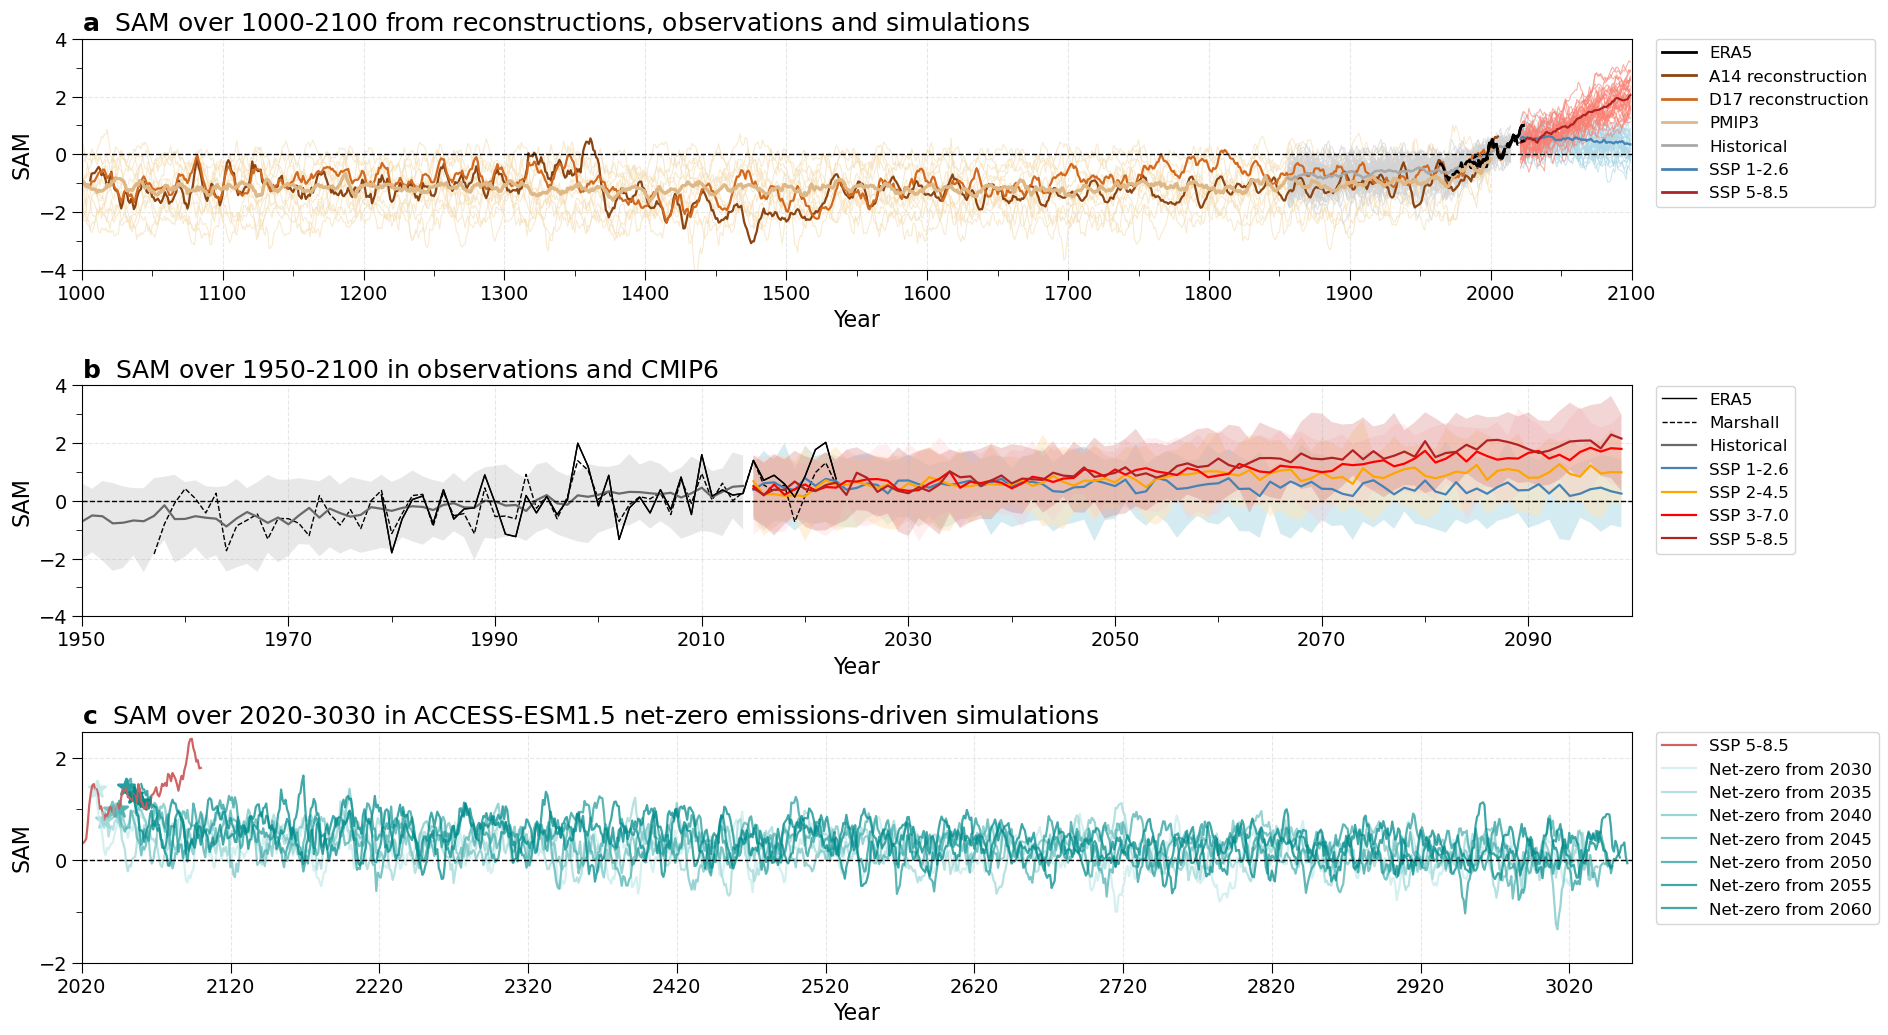

In [8]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(ncols=2, nrows=3, figure=fig)

################################### PANEL 1 ############################################
ax1 = fig.add_subplot(gs[0, :])
ax1.set_title(r'$\bf{a}$  SAM over 1000-2100 from reconstructions, observations and simulations', loc='left', fontsize=18)

for i in range(0, len(var_paleo.models)):
    ax1.plot(var_paleo.rolling(year=7).mean('year').year, var_paleo.rolling(year=7).mean('year')[i, :], color='wheat', linewidth=0.75,alpha=0.65)
for i in range(0, len(var_hist.models)):
    ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.rolling(year=7).mean('year')[i, :], color='lightgrey', linewidth=0.75, alpha=0.65)
for i in range(0, len(var_126.models)):
    ax1.plot(var_126.rolling(year=7).mean('year').year, var_126.rolling(year=7).mean('year')[i, :], color='lightblue', linewidth=0.75, alpha=0.65)
for i in range(0, len(var_585.models)):
    ax1.plot(var_585.rolling(year=7).mean('year').year, var_585.rolling(year=7).mean('year')[i, :], color='salmon', linewidth=0.75, alpha=0.65)

ax1.plot(var_obs.rolling(year=7).mean('year').year, var_obs.rolling(year=7).mean('year'), 'k', linewidth=2, label='ERA5')
ax1.plot(var_recon1.rolling(year=7).mean('year').year, var_recon1.rolling(year=7).mean('year'), 'saddlebrown', linewidth=1.6, label='A14 reconstruction')
ax1.plot(var_recon2.rolling(year=7).mean('year').year, var_recon2.rolling(year=7).mean('year'), 'chocolate', linewidth=1.6, label='D17 reconstruction')
ax1.plot(var_paleo.rolling(year=7).mean('year').year, var_paleo.median(dim='models').rolling(year=7).mean('year'), 'burlywood', linewidth=2.2, label='PMIP3')
ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.median(dim='models').rolling(year=7).mean('year'), 'darkgray', linewidth=1.6, label='CMIP6 - Historical')
ax1.plot(var_126.rolling(year=7).mean('year').year, var_126.median(dim='models').rolling(year=7).mean('year'), 'steelblue', linewidth=1.6, label='CMIP6 - SSP 1-2.6')
ax1.plot(var_585.rolling(year=7).mean('year').year, var_585.median(dim='models').rolling(year=7).mean('year'), 'firebrick', linewidth=1.6, label='CMIP6 - SSP 5-8.5')
ax1.plot(var_obs.rolling(year=7).mean('year').year, var_obs.rolling(year=7).mean('year'), 'k', linewidth=2)
ax1.plot(var_paleo.rolling(year=7).mean('year').year, var_paleo.median(dim='models').rolling(year=7).mean('year'), 'burlywood', linewidth=2.2)
ax1.plot(var_hist.rolling(year=7).mean('year').year, var_hist.median(dim='models').rolling(year=7).mean('year'), 'darkgray', linewidth=1.6, label='CMIP6 - Historical')
ax1.plot(var_obs1.rolling(year=7).mean('year').year, var_obs1.rolling(year=7).mean('year'), 'k', linewidth=2, linestyle='--')

ax1.set_xlim([1000, 2100])  
ax1.set_xticks(np.arange(1000, 2101, 100))  # Major ticks every 100 years
ax1.set_xticks(np.arange(1000, 2101, 50), minor=True)  # Minor ticks every 50 years
ax1.set_ylim([-4, 4])
ax1.set_yticks(np.arange(-4, 4.1, 2))
ax1.set_yticks(np.arange(-4, 4.1, 1), minor=True)
ax1.axhline(0, color='k', linestyle='--', linewidth=1)
ax1.set_ylabel("SAM", fontsize=16)
ax1.set_xlabel("Year", fontsize=16)
ax1.tick_params(which='minor', labelsize=14, length=4)
ax1.tick_params(which='major', labelsize=14, length=7)
ax1.grid(which='major', alpha=0.3, linestyle='dashed')
ax1.legend(handles=[
    Line2D([], [], color='black', linewidth=2, label='ERA5'),
    Line2D([], [], color='saddlebrown', linewidth=2,label='A14 reconstruction'),
    Line2D([], [], color='chocolate', linewidth=2, label='D17 reconstruction'),
    Line2D([], [], color='burlywood', linewidth=2, label='PMIP3'),
    Line2D([], [], color='darkgray', linewidth=2, label='Historical'),
    Line2D([], [], color='steelblue', linewidth=2, label='SSP 1-2.6'),
    Line2D([], [], color='firebrick', linewidth=2, label='SSP 5-8.5'),
], loc='upper left', bbox_to_anchor=(1.01, 1.035), fontsize=12)

################################### PANEL 2 ############################################
ax2 = fig.add_subplot(gs[1,:])
ax2.set_title(r'$\bf{b}$  SAM over 1950-2100 in observations and CMIP6', loc='left', fontsize=18)
ax2.plot(var_obs.year, var_obs, 'k', linewidth=1, label='ERA5')
ax2.plot(var_obs1.year, var_obs1, 'k', linestyle='--', linewidth=1, label='Marshall')
ax2.plot(var_hist.year, var_hist.median(dim='models'), 'dimgray', linewidth=1.6, label='Historical')
ax2.plot(var_126.year, var_126.median(dim='models'), 'steelblue', linewidth=1.6, label='SSP 1-2.6')
ax2.plot(var_245.year, var_245.median(dim='models'), 'orange', linewidth=1.6, label='SSP 2-4.5')
ax2.plot(var_370.year, var_370.median(dim='models'), 'red', linewidth=1.6, label='SSP 3-7.0')
ax2.plot(var_585.year, var_585.median(dim='models'), 'firebrick', linewidth=1.6, label='SSP 5-8.5')
ax2.fill_between(var_hist.year, var_hist.quantile(0.05, dim='models'), var_hist.quantile(0.95, dim='models'), facecolor='lightgrey', alpha=0.5)
ax2.fill_between(var_126.year, var_126.quantile(0.05, dim='models'), var_126.quantile(0.95, dim='models'), facecolor='lightblue', alpha=0.5)
ax2.fill_between(var_245.year, var_245.quantile(0.05, dim='models'), var_245.quantile(0.95, dim='models'), facecolor='moccasin', alpha=0.5)
ax2.fill_between(var_370.year, var_370.quantile(0.05, dim='models'), var_370.quantile(0.95, dim='models'), facecolor='pink', alpha=0.25)
ax2.fill_between(var_585.year, var_585.quantile(0.05, dim='models'), var_585.quantile(0.95, dim='models'), facecolor='indianred', alpha=0.25)

ax2.plot(var_obs.year, var_obs, 'k', linewidth=1)
#ax2.plot(var_obs1.year, var_obs1, 'k', linestyle=':', linewidth=1)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlim([1950, 2100])
ax2.grid(which='major', alpha=0.3, linestyle='dashed')
ax2.set_xticks(np.arange(1950, 2110, 20))
ax2.set_xticks(np.arange(1950, 2100, 10), minor=True)
ax2.set_ylim([-4, 4])
ax2.set_yticks(np.arange(-4, 4.1, 2))
ax2.set_yticks(np.arange(-4, 4.1, 1), minor=True)
ax2.set_ylabel("SAM", fontsize=16)
ax2.set_xlabel("Year", fontsize=16)
ax2.tick_params(which='minor', labelsize=14, length=4)
ax2.tick_params(which='major', labelsize=14, length=7)
ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1.035), fontsize=12)

################################### PANEL 3 ############################################
meantime = 7
ax4 = fig.add_subplot(gs[2,:])
ax4.set_title(r'$\bf{c}$  SAM over 2020-3030 in ACCESS-ESM1.5 net-zero emissions-driven simulations', loc='left', fontsize=18)
ax4.plot(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2020','2100')).time,SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2020','2100')), color='indianred', linewidth=1.6, alpha=0.95, label='SSP 5-8.5')
ax4.plot(SAM1_yr_new.rolling(time=meantime).mean('time').time, SAM1_yr_new.rolling(time=meantime).mean('time'), color=cmap(1 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2030')
ax4.plot(SAM2_yr_new.rolling(time=meantime).mean('time').time, SAM2_yr_new.rolling(time=meantime).mean('time'), color=cmap(2 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2035')
ax4.plot(SAM3_yr_new.rolling(time=meantime).mean('time').time, SAM3_yr_new.rolling(time=meantime).mean('time'), color=cmap(3 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2040')
ax4.plot(SAM4_yr_new.rolling(time=meantime).mean('time').time, SAM4_yr_new.rolling(time=meantime).mean('time'), color=cmap(4 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2045')
ax4.plot(SAM5_yr_new.rolling(time=meantime).mean('time').time, SAM5_yr_new.rolling(time=meantime).mean('time'), color=cmap(5 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2050')
ax4.plot(SAM6_yr_new.rolling(time=meantime).mean('time').time, SAM6_yr_new.rolling(time=meantime).mean('time'), color=cmap(6 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2055')
ax4.plot(SAM7_yr_new.rolling(time=meantime).mean('time').time, SAM7_yr_new.rolling(time=meantime).mean('time'), color=cmap(7 / 7), linewidth=1.6, alpha=0.75,label='Net-zero from 2060')

ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2030','2030')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2030','2030')), marker='*', s=150, color=cmap(1 / 7), edgecolors=cmap(1 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2035','2035')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2035','2035')), marker='*', s=150, color=cmap(2 / 7), edgecolors=cmap(2 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2040','2040')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2040','2040')), marker='*', s=150, color=cmap(3 / 7), edgecolors=cmap(3 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2045','2045')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2045','2045')), marker='*', s=150, color=cmap(4 / 7), edgecolors=cmap(4 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2050','2050')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2050','2050')), marker='*', s=150, color=cmap(5 / 7), edgecolors=cmap(5 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2055','2055')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2055','2055')), marker='*', s=150, color=cmap(6 / 7), edgecolors=cmap(6 / 7), linewidths=2)
ax4.scatter(SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2060','2060')).time, SAM_ACCESS_yr.rolling(time=meantime).mean('time').sel(time=slice('2060','2060')), marker='*', s=150, color=cmap(7 / 7), edgecolors=cmap(7 / 7), linewidths=2)
ax4.set_xlim([cftime.DatetimeProlepticGregorian(2020, 1, 1), cftime.DatetimeProlepticGregorian(3061, 12, 31)])
start_year = cftime.DatetimeProlepticGregorian(2020, 1, 1).year
end_year = cftime.DatetimeProlepticGregorian(3061, 12, 31).year
major_ticks = np.arange(start_year, end_year + 1, 100)
ax4.set_xticks([cftime.DatetimeProlepticGregorian(year, 1, 1) for year in major_ticks])
ax4.set_xticklabels([f'{year}' for year in major_ticks])
ax4.axhline(0, color='k', linestyle='--', linewidth=1)
ax4.grid(which='major', alpha=0.3, linestyle='dashed')
ax4.set_ylim([-1.75, 2.5])
ax4.set_yticks(np.arange(-2, 2.7, 2))
ax4.set_yticks(np.arange(-2, 2.7, 1), minor=True)
ax4.set_ylabel("SAM", fontsize=16)
ax4.set_xlabel("Year", fontsize=16)
ax4.tick_params(which='minor', labelsize=14, length=4)
ax4.tick_params(which='major', labelsize=14, length=7)
ax4.legend(loc='upper left', bbox_to_anchor=(1.01, 1.035), fontsize=12)

plt.subplots_adjust(hspace=0.5)
plt.savefig('Fig4.pdf', dpi=300, bbox_inches='tight')